### Question

In this problem you, can simulate a simplified airport security system at a busy airport. Passengers arrive according to a Poisson distribution with λ1 = 5 per minute (i.e., mean interarrival rate = 0.2 minutes) to the ID/boarding-pass check queue, where there are several servers who each have exponential service time with mean rate = 0.75 minutes. (Hint: model them as one block that has more than one resource.) After that, the passengers are assigned to the shortest of the several personal-check queues, where they go through the personal scanner (time is uniformly distributed between 0.5 minutes and 1 minute). 

Use the Arena software (PC users) or Python with SimPy (PC or Mac users) to build a simulation of the system, and then vary the number of ID/boarding-pass checkers and personal-check queues to determine how many are needed to keep average wait times below 15 minutes. (If you’re using SimPy, or if you have access to a non-student version of Arena, you can use λ1 = 50 to simulate a busier airport.)

### Simulation by Using SimPy in Python

**Building the model**

Following are the simulation model for this question based on SimPy. Based on the model, we record the time point of arrival, starting ID checking, finishing ID checking, starting scanner checking and finishing scanner checking.

So the time metrics are:

*total time of security process = finishing scanner checking - arrival*

*total waiting time in the queue = (starting ID checking - arrival) + (starting scanner checking - finishing ID checking)*

In [100]:
import simpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

class AirportCheck(object):
    '''
    In the ID/boarding-pass check process, the resources are regarded as one block with several counters.
    Passengers wait in one queue.
    
    In the personal scanner process, each counter is regarded as individual queues.
    Passengers choose the shortest one and wait in that queue.
    '''  
    def __init__(self, env, number_IDcheck, number_scanner):
        self.env = env
        self.idcheck_resource = simpy.Resource(env, number_IDcheck)
        self.scanner_resource = []
        for j in range(number_scanner):
            self.scanner_resource.append(simpy.Resource(env, 1))

    def idcheck(self, name, checktime):
        # The ID checking process. Passenger's "name" and the service time are the function's arguements
        # The reason why use name as a argument is that when debugging, it's easier to identify each passenger's state via print(). And same reason for the following part
        yield self.env.timeout(checktime)
        #print("{}'s ID checking time is: {:.2f}".format(name, checktime))
    
    def scancheck(self, name, scantime):
        # The scanner checking process. Passenger's "name" and the service time are the function's arguements
        yield self.env.timeout(scantime)
        #print("{}'s scanner checking time is: {:.2f}".format(name, scantime))


def shortestqueue(queuelist):
    '''
    find the queue with least people
    '''
    lengthlist = [len(line.queue)+len(line.users) for line in queuelist]
    for m in range(len(lengthlist)):
        if lengthlist[m] == 0 or lengthlist[m] == min(lengthlist):
            return m
            break
        

def person(env, name, passenger, checktime, scantime, results):
    '''
    The general process for a passenger to finish the whole process.
    
    ID/boarding-pass check process
    The passenger arrives, waits for ID checking, spends some time in the checking and leaves there.
    
    Personal scanner process
    The passenger chooses the shortest queue, waits for checking, spends some time in the checking and leaves there.
    
    arguement "results" is a empty dict to store the time point
    '''
    # the arrival time of a passenger
    # name also used as key for storing the time points for each passenger
    results[name] = [env.now]
    #print("{} comes at: {:.2f}".format(name, results[name][0]))
    
    # waiting for ID checking
    with passenger.idcheck_resource.request() as request1:
        yield request1
        
        # the time point of starting ID checking
        results[name].append(env.now)
        #print("{} starts ID checking: {:.2f}".format(name, results[name][1]))
        
        # the time spended in checking
        yield env.process(passenger.idcheck(name, checktime))
        
        # the time point of finishing ID checking
        results[name].append(env.now)
        #print("{} finishes ID checking at: {:.2f}".format(name, results[name][2]))
        
    # find the shortest queue
    m = shortestqueue(passenger.scanner_resource)
    #results[name].append(m)
    #print("{} enter queue: {:.0f}".format(name, m))
        
    # waiting for scanning
    with passenger.scanner_resource[m].request() as request2:
        yield request2
        
        #print([len(line.queue)+len(line.users) for line in passenger.scanner_resource])
        # the time point of starting scanner checking
        results[name].append(env.now)
        #print("{} starts scanner checking at: {:.2f}".format(name, results[name][3]))
        #print([len(line.queue)+len(line.users) for line in passenger.scanner_resource])
            
        # the time spended in personal scanner checking
        yield env.process(passenger.scancheck(name, scantime))

        # the time point of finishing scanner checking
        results[name].append(env.now)
        #print("{} finishes scanner checking at: {:.2f}".format(name, results[name][4]))


def setup(env, number_IDcheck, number_scanner, average_time_IDcheck, passengers_per_minute, time_scanner_lower, time_scanner_upper ,initial_passengers, results):

    passeger = AirportCheck(env, number_IDcheck, number_scanner)
    
    # Create initial passengers
    i = 1
    if initial_passengers > 0:
        while i <= initial_passengers:
            checktime = np.random.exponential(scale=average_time_IDcheck*60)
            scantime = np.random.uniform(time_scanner_lower*60, time_scanner_upper*60)
            env.process(person(env, 'Passenger %d' % i, passeger, checktime, scantime, results))
            i += 1

    # Create more passengers while the simulation is running
    while True:
        time_interval = np.random.exponential(scale=60/passengers_per_minute)
        yield env.timeout(time_interval)
        checktime = np.random.exponential(scale=average_time_IDcheck*60)
        scantime = np.random.uniform(time_scanner_lower*60, time_scanner_upper*60)
        env.process(person(env, 'Passenger %d' % i, passeger, checktime, scantime, results))
        i += 1

**Initial trail**

We set the simulation time as 12 hours (43200 seconds) in order to get enough data points.

The parameters are set below. Besides the parameters given in the question, we also set an initial number of passengers to make our simulation closer to realistic situation.

When the average number of passengers arrives per minute is 5, we set the initial number of passengers to 0. The number of servers at ID checking is 5 and the number of personal scanner checking queues is 5, too.

In [101]:
AVERGAE_TIME_IDCHECK = 0.75 # average service time at ID checking, in minute
TIME_SCANNER_LOWER = 0.5 # uniform distribution bound of service time at scanner checking, in minute
TIME_SCANNER_UPPER = 1 # uniform distribution bound of service time at scanner checking, in minute

# key parameters we explore
PASSENGERS_PER_MINUTE = 5 # lambda 1, average number of passengers arrives per minute
NUMBER_IDCHECK = 4 # number of servers at ID checking
NUMBER_SCANNER = 4 # number of personal scanner checking queues
INITIAL_PASSENGERS = 0 # initial number of passengers

timestore={} # store the time point for each passenger

# Setup and start the simulation
SIM_TIME = 43200 # simulation endding time
env = simpy.Environment()
env.process(setup(env, NUMBER_IDCHECK, NUMBER_SCANNER, AVERGAE_TIME_IDCHECK, PASSENGERS_PER_MINUTE, TIME_SCANNER_LOWER, TIME_SCANNER_UPPER, INITIAL_PASSENGERS, timestore))
env.run(until=SIM_TIME)

As a initial trail, we run the simulation once to get some primary impression on the results. As we can see below, the average time of security process is around 204 seconds, and the average waiting time in the queue is around 116 seconds. And there are 3461 passengers arrived at the airport, 3454 of which finish the whole process of secure check.

In [102]:
totaltime = []
waitingtime = []
idt = []
st = []
count = 0 # record how many passengers finish the security check
for p in timestore:
    if len(timestore[p]) == 5:
        count += 1
        totaltime.append(timestore[p][4]-timestore[p][0])
        waitingtime.append(timestore[p][1]-timestore[p][0]+timestore[p][3]-timestore[p][2])
        idt.append(timestore[p][2]-timestore[p][1])
        st.append(timestore[p][4]-timestore[p][3])

print('Average time of security process: {:.2f}'.format(sum(totaltime)/len(totaltime)))
print('Average waiting time in the queue: {:.2f}'.format(sum(waitingtime)/len(waitingtime)))
print('Average ID cheking time: {:.2f}'.format(sum(idt)/len(idt)))
print('Average scanner checking time: {:.2f}'.format(sum(st)/len(st)))
print('Number of passengers arrive at airport:{}'.format(len(timestore)))
print('Number of passengers finish secure check: {}'.format(count))

Average time of security process: 204.27
Average waiting time in the queue: 115.75
Average ID cheking time: 43.14
Average scanner checking time: 45.38
Number of passengers arrive at airport:3461
Number of passengers finish secure check: 3454


Following shows the hisogram and kernel density estimate plot of total time and waiting time. As the number of passengers are relatively small, the distribution is heavily skewed.

Text(0.5, 1.0, 'Distribution of Waiting Time for each Passenger')

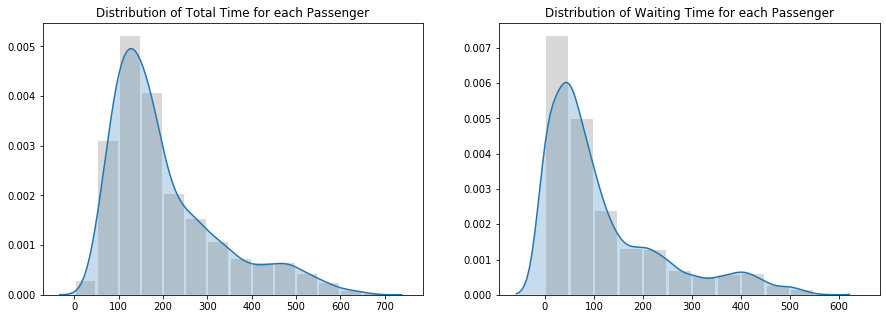

In [103]:
fig = plt.figure(figsize=(15,5))
x1 = range(0,(math.ceil(max(totaltime)/100)+1)*100,50)
x2 = range(0,(math.ceil(max(waitingtime)/100)+1)*100,50)

plt.subplot2grid((1,2),(0,0))
plt.hist(totaltime, bins=x1, rwidth=0.9, density=True, color='grey', alpha=0.3)
sns.kdeplot(totaltime, shade=True)
plt.title('Distribution of Total Time for each Passenger')

plt.subplot2grid((1,2),(0,1))
plt.hist(waitingtime, bins=x2, rwidth=0.9, density=True, color='grey', alpha=0.3)
sns.kdeplot(waitingtime, shade=True)
plt.title('Distribution of Waiting Time for each Passenger')

Then we change the average number of passengers arrives per minute to 50, while the number of servers at ID checking and the number of personal scanner checking queues are changed to 20. And the initial number of passengers change to 30. The situation goes severely bad. In the simulation trail illustrate below, 36109 passengers arrive at airport but only 19150 of them finish the whole checking process. And for the passengers who finish the process, average total time is around 3 hours.

Average time of security process: 10263.32
Average waiting time in the queue: 10173.66
Average ID cheking time: 44.62
Average scanner checking time: 45.04
Number of passengers arrive at airport:36109
Number of passengers finish secure check: 19150


Text(0.5, 1.0, 'Distribution of Waiting Time for each Passenger')

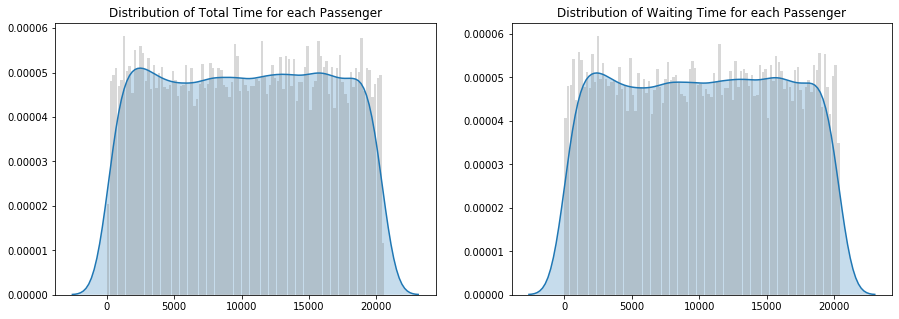

In [110]:
# key parameters we explore
PASSENGERS_PER_MINUTE = 50 # lambda 1, average number of passengers arrives per minute
NUMBER_IDCHECK = 20 # number of servers at ID checking
NUMBER_SCANNER = 20 # number of personal scanner checking queues
INITIAL_PASSENGERS = 30 # initial number of passengers

timestore={} # store the time point for each passenger

# Setup and start the simulation
env = simpy.Environment()
env.process(setup(env, NUMBER_IDCHECK, NUMBER_SCANNER, AVERGAE_TIME_IDCHECK, PASSENGERS_PER_MINUTE, TIME_SCANNER_LOWER, TIME_SCANNER_UPPER, INITIAL_PASSENGERS, timestore))
env.run(until=SIM_TIME)

totaltime = []
waitingtime = []
idt = []
st = []
count = 0 # record how many passengers finish the security check
for p in timestore:
    if len(timestore[p]) == 5:
        count += 1
        totaltime.append(timestore[p][4]-timestore[p][0])
        waitingtime.append(timestore[p][1]-timestore[p][0]+timestore[p][3]-timestore[p][2])
        idt.append(timestore[p][2]-timestore[p][1])
        st.append(timestore[p][4]-timestore[p][3])

print('Average time of security process: {:.2f}'.format(sum(totaltime)/len(totaltime)))
print('Average waiting time in the queue: {:.2f}'.format(sum(waitingtime)/len(waitingtime)))
print('Average ID cheking time: {:.2f}'.format(sum(idt)/len(idt)))
print('Average scanner checking time: {:.2f}'.format(sum(st)/len(st)))
print('Number of passengers arrive at airport:{}'.format(len(timestore)))
print('Number of passengers finish secure check: {}'.format(count))

fig = plt.figure(figsize=(15,5))
x1 = range(0,(math.ceil(max(totaltime)/100)+1)*100,200)
x2 = range(0,(math.ceil(max(waitingtime)/100)+1)*100,200)

plt.subplot2grid((1,2),(0,0))
plt.hist(totaltime, bins=x1, rwidth=0.9, density=True, color='grey', alpha=0.3)
sns.kdeplot(totaltime, shade=True)
plt.title('Distribution of Total Time for each Passenger')

plt.subplot2grid((1,2),(0,1))
plt.hist(waitingtime, bins=x2, rwidth=0.9, density=True, color='grey', alpha=0.3)
sns.kdeplot(waitingtime, shade=True)
plt.title('Distribution of Waiting Time for each Passenger')

**How many security resource are needed to keep waiting time under 15 minutes?**

In the two examples above, we show two simulation trails in which the parameters are:

1).ID checking resource = 10, scanner resource = 10, number of average arrival per minute = 10, initial passengers = 0

2).ID checking resource = 10, scanner resource = 10, number of average arrival per minute = 50, initial passengers = 50

Under condition one, the waiting time is quite short. While as number of passengers getting larger in condition two, waiting time becomes severely long.

In the following session, we will explore how many resources are needed when the number of average arrival per minute equal to 5 or 50 in order to keep the average total time under 15 mintes. Because there are randomness in each simulation, we run the simulation under one condition for 100 times. The matric we use is the maximum average total time and maximum average waiting time in 100 trails.

**Number of average arrival per minute = 5**

In [105]:
parameters = [str(num) for num in range(3,6)]

data_total = pd.DataFrame(index=parameters, columns=parameters)
data_waiting = pd.DataFrame(index=parameters, columns=parameters)

for a in range(len(parameters)):
    for b in range(len(parameters)):
        # key parameters we explore
        PASSENGERS_PER_MINUTE = 5 # lambda 1, average number of passengers arrives per minute
        INITIAL_PASSENGERS = 0 # initial number of passengers
        NUMBER_IDCHECK = int(data_total.index[a]) # number of servers at ID checking
        NUMBER_SCANNER = int(data_total.columns[b]) # number of personal scanner checking queues
    
        simulationtimes = 100
    
        total = 0
        waiting = 0
    
        for c in range(simulationtimes):
            timestore={}
            env = simpy.Environment()
            env.process(setup(env, NUMBER_IDCHECK, NUMBER_SCANNER, AVERGAE_TIME_IDCHECK, PASSENGERS_PER_MINUTE, TIME_SCANNER_LOWER, TIME_SCANNER_UPPER, INITIAL_PASSENGERS, timestore))
            env.run(until=SIM_TIME)
        
            totaltime = []
            waitingtime = []
            for p in timestore:
                if len(timestore[p]) == 5:
                    totaltime.append(timestore[p][4]-timestore[p][0])
                    waitingtime.append(timestore[p][1]-timestore[p][0]+timestore[p][3]-timestore[p][2])
        
            # store the results of one simulation
            if total < sum(totaltime)/len(totaltime):
                total = sum(totaltime)/len(totaltime)
            if waiting < sum(waitingtime)/len(waitingtime):
                waiting = sum(waitingtime)/len(waitingtime)
    
        data_total.loc[data_total.index[a], data_total.columns[b]] = total
        data_waiting.loc[data_total.index[a], data_total.columns[b]] = waiting

The following heatmap shows that when ID checking servers = 4 and scanners = 4, the average security checking time will under 15 minutes. Meanwhile, when the number of checking servers increases to 4 or the number of scanner queues increases to 4, the efficiency is promoted dramatically. 

Besides, ID checking is the relative bottleneck in this system. Increasing the resource in ID checking is more effective compared with adding more scanner queues.

Text(0.5, 1, 'Heatmap of Average Total Security Checking Time (min)')

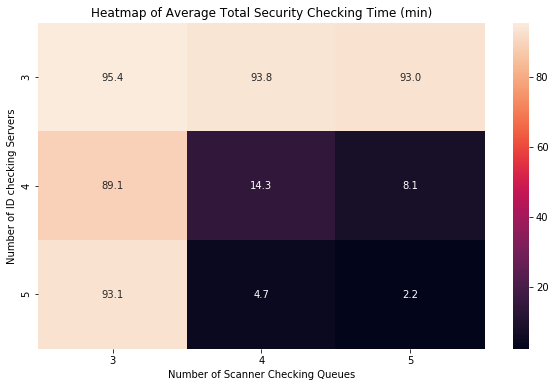

In [106]:
data_total = data_total[data_total.columns].astype(float)
data_total = data_total[data_total.columns]/60
fig=plt.figure(figsize=(10,6))
sns.heatmap(data_total, annot=True, fmt='.1f')
plt.xlabel("Number of Scanner Checking Queues")
plt.ylabel("Number of ID checking Servers")
plt.title("Heatmap of Average Total Security Checking Time (min)")

For the waiting time in the queue, the trend is similar.

Text(0.5, 1, 'Heatmap of Average Waiting Time (min)')

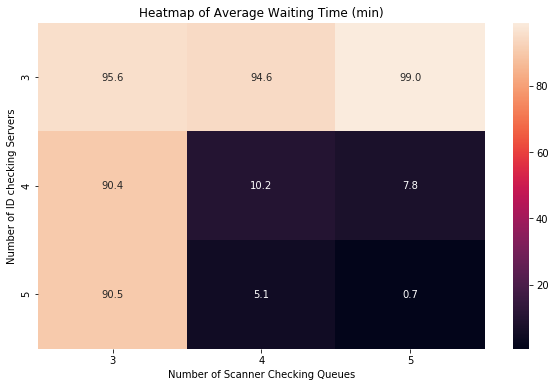

In [96]:
data_waiting = data_waiting[data_waiting.columns].astype(float)
data_waiting = data_waiting[data_waiting.columns]/60
fig=plt.figure(figsize=(10,6))
sns.heatmap(data_waiting, annot=True, fmt='.1f')
plt.xlabel("Number of Scanner Checking Queues")
plt.ylabel("Number of ID checking Servers")
plt.title("Heatmap of Average Waiting Time (min)")

**Number of average arrival per minute = 50**

In [107]:
parameters = [str(num) for num in range(33,42,3)]

data_total = pd.DataFrame(index=parameters, columns=parameters)
data_waiting = pd.DataFrame(index=parameters, columns=parameters)

for a in range(len(parameters)):
    for b in range(len(parameters)):
        # key parameters we explore
        PASSENGERS_PER_MINUTE = 50 # lambda 1, average number of passengers arrives per minute
        INITIAL_PASSENGERS = 30 # initial number of passengers
        NUMBER_IDCHECK = int(data_total.index[a]) # number of servers at ID checking
        NUMBER_SCANNER = int(data_total.columns[b]) # number of personal scanner checking queues
    
        simulationtimes = 100
    
        total = 0
        waiting = 0
    
        for c in range(simulationtimes):
            timestore={}
            env = simpy.Environment()
            env.process(setup(env, NUMBER_IDCHECK, NUMBER_SCANNER, AVERGAE_TIME_IDCHECK, PASSENGERS_PER_MINUTE, TIME_SCANNER_LOWER, TIME_SCANNER_UPPER, INITIAL_PASSENGERS, timestore))
            env.run(until=SIM_TIME)
        
            totaltime = []
            waitingtime = []
            for p in timestore:
                if len(timestore[p]) == 5:
                    totaltime.append(timestore[p][4]-timestore[p][0])
                    waitingtime.append(timestore[p][1]-timestore[p][0]+timestore[p][3]-timestore[p][2])
        
            # store the results of one simulation
            if total < sum(totaltime)/len(totaltime):
                total = sum(totaltime)/len(totaltime)
            if waiting < sum(waitingtime)/len(waitingtime):
                waiting = sum(waitingtime)/len(waitingtime)
    
        data_total.loc[data_total.index[a], data_total.columns[b]] = total
        data_waiting.loc[data_total.index[a], data_total.columns[b]] = waiting

As for the average number of passenger arriving per minute equals to 50, opening about 35-40 ID checking servers and 35-40 scanner queues will be an ideal condition in which the average security checking time will goes below 30 minutes.

Text(0.5, 1, 'Heatmap of Average Total Security Checking Time (min)')

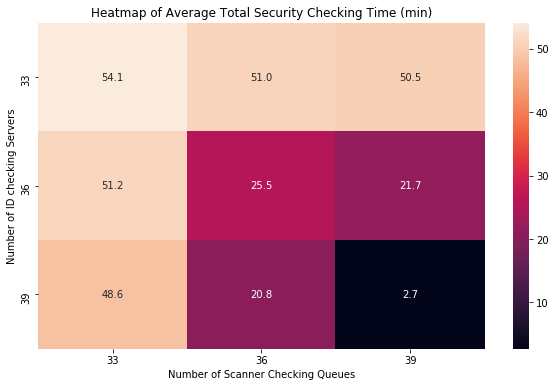

In [108]:
data_total = data_total[data_total.columns].astype(float)
data_total = data_total[data_total.columns]/60
fig=plt.figure(figsize=(10,6))
sns.heatmap(data_total, annot=True, fmt='.1f')
plt.xlabel("Number of Scanner Checking Queues")
plt.ylabel("Number of ID checking Servers")
plt.title("Heatmap of Average Total Security Checking Time (min)")

Text(0.5, 1, 'Heatmap of Average Waiting Time (min)')

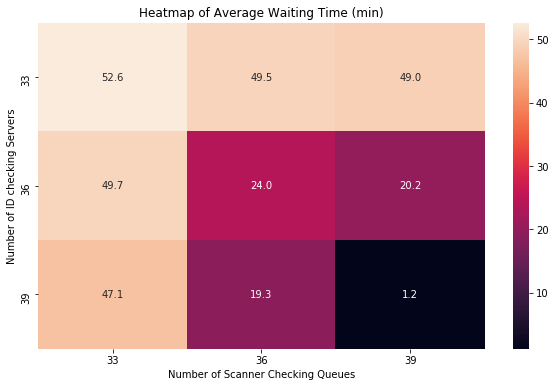

In [109]:
data_waiting = data_waiting[data_waiting.columns].astype(float)
data_waiting = data_waiting[data_waiting.columns]/60
fig=plt.figure(figsize=(10,6))
sns.heatmap(data_waiting, annot=True, fmt='.1f')
plt.xlabel("Number of Scanner Checking Queues")
plt.ylabel("Number of ID checking Servers")
plt.title("Heatmap of Average Waiting Time (min)")